# COSC 526 - Assignment 06
### February 26, 2021
---

*Note: Running a cell will not rerun previous cells.  If you edit code in previous cells, you must rerun those cells.  We recommend using* `Run All` *to avoid any errors results from not rerunning previous cells.  You can find this in the menu above:* `Cell -> Run All`

During the last lecture, we learned about the **Apache Spark** implementation of the **MapReduce** programming model.  In this assignment, we will use **PySpark** (the Spark Python API) to perform one of the text parsing problems that we solved in the last assignment *with the power of parallel processing*. In the previous assignment, we defined three sequential methods (i.e., `mapSequential`, `reduceSequential`, and `reduceByKeySequential`) that extend Python's `map` and `reduce` functions.  In this assignment, we will be using PySpark's parallel version of these functions.

### Testing PySpark
Run the cell below to verify that your Java, Spark, and PySpark installations are successful. The cell generates a dataset of numbers (i.e., 1, 2, 3, 4, 5, 6, 7, 8, 9, and 10) and computes their sum. The expected output is 45.

In [47]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
data = sc.parallelize(range(1,10))
print(data.reduce(lambda x,y: x+y))
sc.stop()

45


### Problem 0:
Now that we are in Jetstream, open your completed Assignment05 and rerun it. Executing the same code on different machines is a valuable test of the portability of your code.

### Problem 1:

Now that we have Spark installed and running in our Jupyter Notebook environment, we can move from *sequential* text processing in Python (i.e., Assignments 4 and 5) to the *parallel* implementation in *Apache Spark*.  **In this assignment we will redo the problems from Assignment05 using Apache Spark.**  *Note that the code you wrote for the sequential version should work with the parallel version.  You will only need to adapt to using Spark's parallelized data structure, the `RDD`.* 

Below, we provide the functions implemented in the Assignment04 (e.g., the building blocks of analyses provided by domain scientists, that you are asked to parallelize).  Notice the one minor change from the previous assignment: the `preprocessLine` function is similar to `loadText` but it is designed to operate on a single line as opposed to an entire file.  This allows the pre-processing to occur on each line in the file in parallel.

In [48]:
# Define a method for reading and processing individual lines of a text file
# Like `loadText` in assignment 5 except that it operates on a single line, rather than an entire file
def preprocessLine(line):
    import re
    
    # Remove all non-alphabet characters with a regular expression
    text_alpha = re.sub(r'[^a-zA-Z]', ' ', line)

    # Convert characters to upper-case
    text_upper = text_alpha.upper()
    
    # Convert the string of text into a list of words and remove empty words
    words = [w for w in text_upper.split(' ') if w != '']
    
    return words

# Return the length of a given word
def wordLength(word):
    return len(word)

# Given a key and value, return a (key, value) pair
def makeKeyValue(key, value=1):
    return (key, value)

# Count (reduce) the values for a given key (word length)
def addValues(val1, val2):
    return val1 + val2

# Given a word, return an iterable of characters
def splitWord(word):
    return list(word)

# Define a method to return position of each character
def lettersPosition(word):
    import numpy as np

    if len(word) == 1:
        # Base case for words of length 1
        return [(word, np.array([1,0,0]))]
    else:
        # Get first and last letters
        first, last = word[0], word[-1]
        pos_list = [(first, np.array([1,0,0])), (last, np.array([0,0,1]))]

        # Get interior letters
        interior = word[1:-1]
        for char in interior:
            pos_list.append((char, np.array([0,1,0])))

    return pos_list

Create a Spark Context and use the new preProcessLine function to import the text from The Count of Monty.

In [49]:
# Create the Spark Context (sc)
# <Define your Spark Context here>
sc = SparkContext.getOrCreate()
# Create the RDD containing the text from the Count of Monte Cristo
# HINT: ref 1
textFile = sc.textFile("book_CountOfMonteCristo.txt")
# data = textFile.collect()
# rdd = sc.parallelize(data)

# Pre-process the lines in the RDD
# (i.e., remove special characters, make uppercase, split into words)
# What kind of Spark map function do you need in this situation?
# Think about the structure of what is returned by each call to the map fuction,
# and about what you want the final structure to be
# HINT: ref 2 or 3

words = textFile.flatMap(preprocessLine)

Analyze the text for word length frequency. We might expect short words to be more common than long words. But, are words of length 2 more common than words or length 3? Are words of length 3 more common that words of length 4? **Use the pre-processed text, `words`, from the previous cell to count the frequency of each word length in the text using the parallel MapReduce methods of Spark.**

In [50]:
# Map the length of each word, using the wordLength function defined above
# HINT: ref 3
word_lengths = words.map(wordLength)
    
# Map keyvalue pairs to help count each word length, using the makeKeyValue function defined above
word_keyvalues = word_lengths.map(makeKeyValue)
# print(word_keyvalues[:10])
    
# ReduceByKey to count number of words with each length, using the addValues function defined above
# HINT: ref 4
word_length_counts = word_keyvalues.reduceByKey(addValues)
# print(word_length_counts[:10])

# Extract the six most common word-lengths from the RDD
# HINT: ref 5
wl_counts_sorted = word_length_counts.top(6,key=lambda x: x[1])

# Print the 6 most common word lengths
print('Word Length : Count')
for word_len, count in wl_counts_sorted[:6]:
    print('{:<11d} : {:>6d}'.format(word_len, count))

Word Length : Count
3           : 109798
2           :  84021
4           :  81777
5           :  49101
6           :  39015
7           :  30701


#### Expected Output:
```
Word Length : Count
3           : 109798
2           :  84021
4           :  81777
5           :  49101
6           :  39015
7           :  30701
```
#### References
- [1: textFile](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext.textFile)
- [2: flatMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.flatMap)
- [3: map](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.map)
- [4: reduceByKey](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey)
- [5: top](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.top)

### Problem 2:
Analyze the text for letter frequency. If you’ve taken a crypto course and/or have seen substitution ciphers then you are probably aware that ’e’ is the most common letter used in the English language.  **Use the pre-processed text `words` to count the frequency of each letter in the text using the parallel MapReduce methods of Spark**.

In [51]:
# The next two calls require you to use the map function
# Think about which map (i.e., flatMap or Map) is most suitable


# Map list of words to list characters, using the splitWord function defined above
chars = words.flatMap(splitWord)

# Map list of characters to list of key-value pairs, using the makeKeyValue function defined above
char_keyvalues = chars.map(makeKeyValue)

# ReduceByKey to count number of occurrences of each letter
char_counts = char_keyvalues.reduceByKey(addValues)

# Extract the 6 most common characters from the RDD
char_counts_sorted = char_counts.top(6,key=lambda x: x[1])

# Print the 6 most common characters
print('Character : Count')
for letter, count in char_counts_sorted[:6]:
    print('{:<9s} : {:>6d}'.format(letter, count))


Character : Count
E         : 258693
T         : 180211
A         : 165306
O         : 156817
I         : 142095
N         : 137343


#### Expected Output:
```
Character : Count
E         : 258693
T         : 180211
A         : 165306
O         : 156817
I         : 142095
N         : 137343
```

### Problem 3:
If we really wanted to crack a substitution cipher (or win on "Wheel of Fortune") then we should be aware that, although 'e' is the most common letter used in English, it may not be the most common first letter in a word. **Count the positional frequencies of each letter using the parallel MapReduce methods of Spark. Specifically, count the number of times each letter appears as the first letter in a word, as the last letter in a word, and as an interior letter in a word (i.e. a letter that is neither first nor last)**. 

In [52]:
# Map the location of each character within the words
char_positions = words.flatMap(lettersPosition)

# Reduce the letter positions for each character
char_position_counts = char_positions.reduceByKey(addValues)

# Collect the counts for the first 6 characters in the alphabet (i.e., A-F)
# HINT: ref 1
cp_sorted = char_position_counts.takeOrdered(6,key=lambda x: x[0])

# Print the position frequency of the first letters in the alphabet
print('Character : First | Interior |  Last')
for char, char_position in cp_sorted[:6]:
    first, interior, last = char_position
    print('{:<9} : {:5d} | {:>8d} | {:>5d}'.format(char, first, interior, last))


Character : First | Interior |  Last
A         : 51644 |   111686 |  1976
B         : 18866 |     8516 |   541
C         : 19577 |    32130 |   725
D         : 17289 |    18613 | 58075
E         : 10178 |   153205 | 95310
F         : 17724 |    10618 | 16988


#### Expected Output:
```
Character : First | Interior |  Last
A         : 51644 |   111686 |  1976
B         : 18866 |     8516 |   541
C         : 19577 |    32130 |   725
D         : 17289 |    18613 | 58075
E         : 10178 |   153205 | 95310
F         : 17724 |    10618 | 16988
```
#### References
- [1: takeOrdered](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.takeOrdered)

### Problem 4:
As you did in Problem 4 of Assignment04, use matplotlib to create histograms for Problems 1-3.

In [53]:
# Import matplotlib's pyplot
from matplotlib import pyplot as plt
import numpy as np

Plot word_length_counts from Problem 1, ordered by word length.

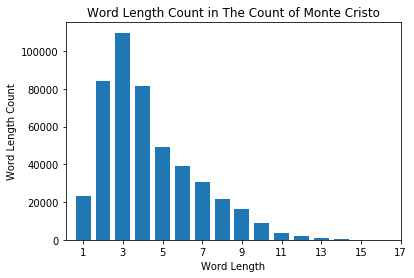

In [54]:
# Collect the data from the RDD into a list
# HINT: ref[1]
word_length_counts_collected = word_length_counts.collect()

# Sort word length list by length of word
wl_sorted = sorted(word_length_counts_collected, key=lambda x: x[0])

# Get X and Y values
X_vals, Y_vals = zip(*wl_sorted)

# Plot the histogram
plt.bar(X_vals, Y_vals, 0.75)
plt.xlim((.125, len(X_vals)))
plt.xticks(range(1,len(X_vals)+1,2))
plt.xlabel('Word Length')
plt.ylabel('Word Length Count')
plt.title('Word Length Count in The Count of Monte Cristo')
plt.show()


Plot char_counts from Problem 2, ordered alphabetically.

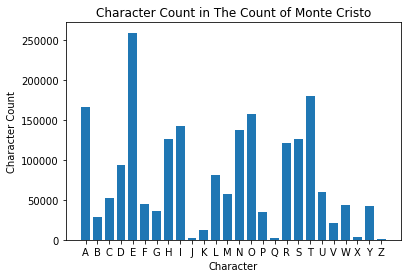

In [55]:
# Make sure you clear (i.e., delete) previous figures with this
plt.clf()

# Collect the data from the RDD into a list
char_counts_collected = char_counts.collect()

# Sort character count list alphabetically
w2_sorted = sorted(char_counts_collected, key=lambda x: x[0])

# Use the sorted list of tuples contain characters and character counts to get X and Y values
XCharacter_vals, YCharacter_vals = zip(*w2_sorted)

# Plot the histogram

plt.bar(XCharacter_vals, YCharacter_vals, 0.75)
# plt.xlim((0, len(XCharacter_vals)))
plt.xticks(range(0,len(XCharacter_vals),1))
plt.xlabel('Character')
plt.ylabel('Character Count')
plt.title('Character Count in The Count of Monte Cristo')
plt.show()

Plot char_position_counts from Problem 3, ordered alphabetically with three bars per letter.

<Figure size 432x288 with 0 Axes>

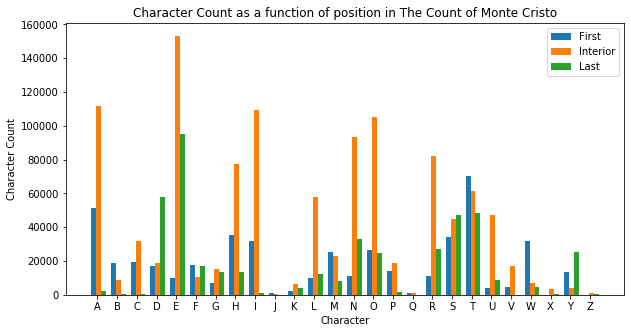

In [56]:
# Clear previous figure
plt.clf()

# Collect the data from the RDD into a list
char_position_counts_collected = char_position_counts.collect()

# Sort the list of character position count values alphabetically
w3_sorted = sorted(char_position_counts_collected, key=lambda x: x[0])

# Get a list of X values and 3 lists for Y values (first, interior, and last)
XCharacterPos_vals, YCharacterPos_vals = zip(*w3_sorted)
YFirst, YInterior, YLast = zip(*YCharacterPos_vals)


# Set proper X_pos values for each list of values (first, interior, last)
x=np.arange(len(XCharacterPos_vals))
plt.figure(figsize=(10,5))
width=0.25
plt.bar(x-width,YFirst,width, label='First')
plt.bar(x,YInterior,width, label='Interior')
plt.bar(x+width, YLast, width, label='Last')
plt.xticks(x-(width/4), XCharacterPos_vals)

plt.title('Character Count as a function of position in The Count of Monte Cristo')
plt.xlabel('Character')
plt.ylabel('Character Count')

plt.legend()
plt.show()

# Plot the histograms



#### References
- [1: collect](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collect)

In [57]:
# Stop the Spark Context
sc.stop()

### Problem 5:
**Find an interesting dataset.**

Now that you've heard a bit about the projects we will be doing later in this class, find a dataset that you *could* use for the project. It should be large enough to allow for interesting analysis and non-trivial results. You don't have to download the data; make sure you do NOT add it to your GitHub repository.

In the box below, describe the dataset you have selected in one or two paragraphs. Include its source (with url); how the data were collected; significance of the data; the number of rows, objects, or data points; what information is contained in each; data types (int, str, char, float, etc.) and numerical ranges where appropriate; and any details about the file that would be necessary for loading the data into a program.

**NOTE: You will not have to use this dataset for your project! This is an exercise in finding and describing data for research.**

The dataset is on "Nutrition, Physical Activity, and Obesity - Behavioral Risk Factor Surveillance System". Available from CDC via data.gov 
https://catalog.data.gov/dataset/nutrition-physical-activity-and-obesity-behavioral-risk-factor-surveillance-system

It includes data on adult's diet, physical activity, and weight status from Behavioral Risk Factor Surveillance System. This data provides national and state specific data on obesity, nutrition, physical activity, and breastfeeding.

The dataset consists of two csv files. One has 48,772 rows and 33 columns and the other one has 9 rows and 7 columns.
Some of the columns are state names, years, income, age, source of the data, type of the disease studied etc.
It consists of different data types including int, str, char, float, etc

### Things to Consider:
* You used the collect() function for Problem 4 to move the data from RDDs to lists. This collects the distributed data, which is okay for the small datasets used presently, but would be unwise if you are using Spark to handle very large datasets.
* Parallel computation can save time by completing multiple pieces of work simultaneously on different processors. However, if you were to track execution time for Problems 1-3 above and compare it with Assignment05, Assignment06 could very well be slower. Why?
* When our dataset was a text, the questions we asked included "How often does each word-length occur?" and "How often does each letter occur?" Consider what questions you could ask about the dataset you described in Problem 5.

### Assignment Questions:
**Answer the following questions, in a couple sentences each, in the cells provided below**
* List the key tasks you accomplished during this assignment?
* Describe the challenges you faced in addressing these tasks and how you overcame these challenges?
* Did you work with other students on this assignment? If yes, how did you help them? How did they help you? Be as specific as possible.

* Successfully used pySpark to analyze a text file.
* At first, I didn't know about the different commands of Spark, but after going through the documentation, it beacame clear.
* No